### What happens if you just turn off the 3PN AND 3.5PN TaylorF2 terms and compare that to EOB?

Does EOB include 3PN and 3.5PN spin-orbit terms?

Justin says: spin-orbit begins at 1.5PN. 3PN corresponds to 1.5PN after that. Only even PN orders beyond the leading term exists in the conservative Hamiltonian. Thus, there is a 2.5PN S-O conservative term (1PN beyond leading order), but there is not a 3PN S-O term in the Hamiltonian. The flux, given by the waveform, does have 3PN S-O terms. So, technically the EOB waveform does include the 3PN spin-orbit terms.

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.2.2'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

In [185]:
import time

# Methods for the training set

In [5]:
def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

In [6]:
def zero_start_slope(h, fi, ff):
    """Subtract a linear fit from the waveform phase.
    Line is fit in the interval (fi, ff).
    """
    # Indices for interval (fi, ff)
    fit_i = np.where((h.x>=fi) & (h.x<=ff))
    freq = h.x[fit_i]
    phase = h.phase[fit_i]
    # Fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(freq, phase)
    # Equation for line for all frequencies in dh
    y_fit = intercept + slope*h.x
    # Subtract the fit
    hzero = h.copy()
    hzero.phase -= y_fit
    return hzero

In [7]:
def fourier_transform_waveform(h, delta_t, n_ext, winon_i, winon_f, trunc_i, trunc_f, npoints=10000, win='planck'):
    """Window --> pad --> Fourier Transform --> resample.
    """
    condition = traineob.ConditionedWaveform(h)

    # Resample the waveform
    condition.resample_uniform(delta_t)

    # Window the waveform
    condition.window_freq_on(winon_i, winon_f, win=win)


    # Pad the end of the waveform with zeros
    condition.extend_with_zeros(n_ext)

    # Fourier transform
    condition.fourier_transform()

    # Resample Fourier transformed waveform with log-spacing to compress it.
    # Start at winon_i instead of 0 since you can't take the log of 0.
    htilde = condition.h
    wave.resample_uniform(htilde, xi=trunc_i, xf=trunc_f, npoints=npoints, spacing='log', order=2)
    
    return htilde

# Universal relation for quadrupole moment

In [129]:
def quad_of_lambda_fit_sebastiano(lam):
    """This function computes the quadrupole induced by rotation. 
    Reference: Yunes-Yagi, PRD 88, 023009.logQ-vs-log(lambda) fit of Table I of Yunes-Yagi
    here x = log(lambda) and the output is the log of the coefficient
    that describes the quadrupole deformation due to spin.
    
    Warning: This is not the same fit as the AEI version (https://arxiv.org/abs/1303.1528)
    """
    ai = 0.194;
    bi = 0.0936;
    ci = 0.0474;
    di = -4.21e-3;
    ei = 1.23e-4;
    
    x = np.log(lam)
    y = ai + bi*x + ci*x**2 + di*x**3 + ei*x**4
    return np.exp(y)

In [130]:
epsilon = 1.0e-11
print f2.quad_of_lambda_fit(1-epsilon)/f2.quad_of_lambda_fit(1+epsilon)

0.9999999999981675


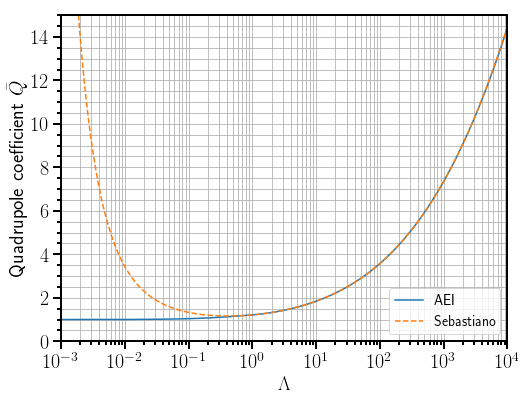

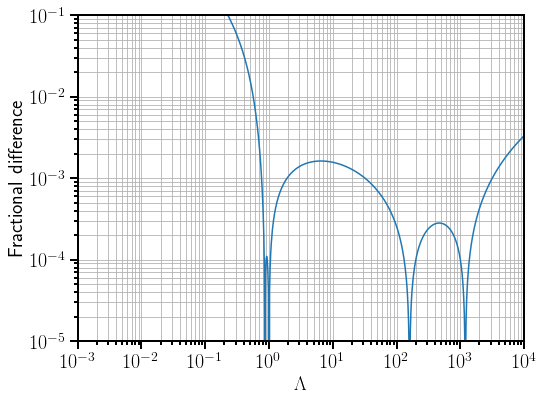

In [140]:
lam = np.logspace(-5, 4, 1000)
quad_aei = np.array([f2.quad_of_lambda_fit(l) for l in lam])
quad_sebastiano = np.array([quad_of_lambda_fit_sebastiano(l) for l in lam])

fig, ax = plt.subplots()
ax.plot(lam, quad_aei, label='AEI')
ax.plot(lam, quad_sebastiano, ls='--', label='Sebastiano')

ax.set_xscale('log')
ax.set_xlim(0.001, 10000.0)
ax.set_ylim(0, 15.0)
ax.minorticks_on()
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'Quadrupole coefficient $\bar Q$')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

fig, ax = plt.subplots()
ax.plot(lam, np.abs(quad_sebastiano/quad_aei-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.001, 10000.0)
ax.set_ylim(1.0e-5, 0.1)
ax.minorticks_on()
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel('Fractional difference')
ax.minorticks_on()
ax.grid(which='both')

# Load time-domain EOB waveforms

In [70]:
orig_filename = '../../data/TEOBv4_20hz/TEOB_data_train_corners_lhd.hdf5'
params_noqm, hnoqm_list = load_eob_training_set_td(orig_filename)

orig_filename = '../../data/TEOBv4QM_20hz/TEOB_data_train_corners_lhd.hdf5'
params_qm, hqm_list = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 20
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 
        approximant = SEOBNRv4T
        M = 2
        fs = 32768
        iota = 0
        f_min = 20
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'a

# Verify by directly calculating time domain code:

In [172]:
import lalsimulation as LS
import lal

def spin_tidal_eob(
    m1, m2, s1z, s2z, lambda1, lambda2,
    f_min, 
    delta_t=1.0/16384.0, distance=1.0, inclination=0.0,
    approximant='SEOBNRv4T', 
    dquadmon1=None, dquadmon2=None, 
    verbose=True):
    """EOB waveform with aligned spin and tidal interactions. 
    l=3 tidal interaction and l=2,3 f-mode calculated with universal relations.
    
    Parameters
    ----------

    Returns
    -------
    Waveform object
    """
    # print m1, m2, s1z, s2z, lambda1, lambda2, f_min, delta_t, distance, inclination
    f_ref = 0.
    phiRef = 0.
    
    # Must have aligned spin
    s1x, s1y, s2x, s2y = 0., 0., 0., 0.
    
    # Eccentricity is not part of the model
    longAscNodes = 0.
    eccentricity = 0.
    meanPerAno = 0.
    
    # Set the EOB approximant
    #if (approximant not in ['TEOBv2', 'TEOBv4', 'SEOBNRv2T', 'SEOBNRv4T']):
    #    raise Exception, "Approximant must be 'TEOBv2' or 'TEOBv4' or 'SEOBNRv2T' or 'SEOBNRv4T'."
    lal_approx = LS.GetApproximantFromString(approximant)
    
    # Insert matter parameters
    lal_params = lal.CreateDict()
    LS.SimInspiralWaveformParamsInsertTidalLambda1(lal_params, lambda1)
    LS.SimInspiralWaveformParamsInsertTidalLambda2(lal_params, lambda2)
    
    # Manually set quadrupole term. Uses Yagi fits by default
    if dquadmon1 is not None:
        LS.SimInspiralWaveformParamsInsertdQuadMon1(lal_params, dquadmon1)
    if dquadmon2 is not None:
        LS.SimInspiralWaveformParamsInsertdQuadMon2(lal_params, dquadmon2)
        
    # Evaluate waveform
    hp, hc = LS.SimInspiralChooseTDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 
        s1x, s1y, s1z, s2x, s2y, s2z, 
        distance*10**6*lal.PC_SI,
        inclination, phiRef, longAscNodes, eccentricity, meanPerAno,
        delta_t, f_min, f_ref, lal_params, lal_approx)
    
    if verbose:
        ap = LS.GetStringFromApproximant(lal_approx)
        L2A = LS.SimInspiralWaveformParamsLookupTidalLambda1(lal_params)
        L2B = LS.SimInspiralWaveformParamsLookupTidalLambda2(lal_params)
        L3A = LS.SimInspiralWaveformParamsLookupTidalOctupolarLambda1(lal_params)
        L3B = LS.SimInspiralWaveformParamsLookupTidalOctupolarLambda2(lal_params)
        w2A = LS.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode1(lal_params)
        w2B = LS.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode2(lal_params)
        w3A = LS.SimInspiralWaveformParamsLookupTidalOctupolarFMode1(lal_params)
        w3B = LS.SimInspiralWaveformParamsLookupTidalOctupolarFMode2(lal_params)
        dquadmon1 = LS.SimInspiralWaveformParamsLookupdQuadMon1(lal_params)
        dquadmon2 = LS.SimInspiralWaveformParamsLookupdQuadMon2(lal_params)
        print 'Approximant: '+str(ap)
        print 'm1={:.2f}, m2={:.2f}'.format(m1, m2)
        print 's1z={:.2f}, s2z={:.2f}'.format(s1z, s2z)
        print 'delta_t={:.6f}, 1/delta_t={:.5}, f_min={:.2f}'.format(delta_t, 1./delta_t, f_min)
        print 'L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:'
        print '{:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(
            L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B, dquadmon1, dquadmon2)
        sys.stdout.flush()
    
    # Extract time array from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds*1.0e-9 
    ts = tstart + hp.deltaT*np.arange(hp.data.length)
    
    return ts, hp.data.data, hc.data.data

In [173]:
i = 33
q, s1z, s2z, lambda1, lambda2 = params_qm[i]
print q, s1z, s2z, lambda1, lambda2

# q = 1.0
# s1z = 0.5
# s2z = 0.5
# lambda1 = 0.1
# lambda2 = 0.1

f_min = 200.0

mtot = 2.0
m1 = mtot/(1.0+q)
m2 = mtot*q/(1.0+q)
print m1, m2, m2/m1

ts, hp, hc = spin_tidal_eob(
    m1, m2, s1z, s2z, lambda1, lambda2,
    f_min, 
    delta_t=1.0/16384.0, distance=1.0, inclination=0.0,
    approximant='SEOBNRv4T', 
    dquadmon1=0.0, dquadmon2=0.0, 
    verbose=True)

0.8110236220472441 0.2637795275590551 0.4921259842519685 4133.858267716535 4173.228346456693
1.1043478260869566 0.8956521739130435 0.8110236220472441
Approximant: SEOBNRv4T
m1=1.10, m2=0.90
s1z=0.26, s2z=0.49
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=200.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
4133.9, 4173.2, 17694.4, 17928.0, 0.0460, 0.0458, 0.0632, 0.0631, 0.0000, 0.0000


In [71]:
f2.quad_of_lambda_fit(lambda1)-1, f2.quad_of_lambda_fit(lambda2)-1

(10.237129426254723, 10.268013501118098)

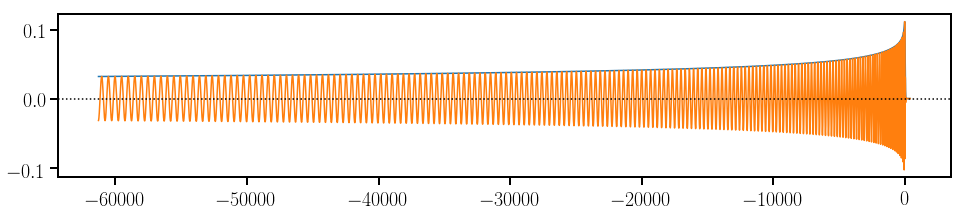

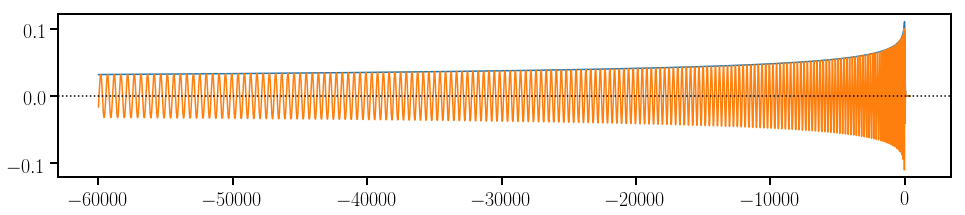

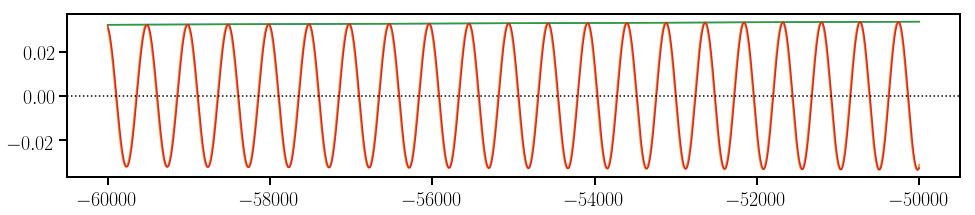

In [84]:
h_lal = wave.Waveform.from_hp_hc(ts, hp, hc)

mtot = 2.0
dist = 1.0
h_lal = wave.physical_to_dimensionless_time(h_lal, mtot, dist)

fig, ax = wave.plot_waveforms([h_lal], npoints=100000)

i = 33
h_michael = hqm_list[i].copy()
fig, ax = wave.plot_waveforms([h_michael], xi=-60000, npoints=100000)

h_michael.add_phase(2.3)
fig, ax = wave.plot_waveforms([h_lal, h_michael], xi=-60000, xf=-50000, npoints=100000)

## Sebastiano's code

Review of TEOBResumS and install instructions:

https://www.lsc-group.phys.uwm.edu/ligovirgo/cbcnote/TEOBResumS

bitbucket repository:

https://bitbucket.org/eob_ihes/teobresums

make -f Makefile.TEOBResumS

Compile in this directory: /Users/lackey/src/teobresums/C++

Then: `chmod u+x TEOBResumS.x`

run with: `/Users/lackey/src/teobresums/C++/TEOBResumS.x [OPTIONS]`

logQ(Lambda) from Yagi fit is calculated here: https://bitbucket.org/eob_ihes/teobresums/src/f91e0c8ca12bbc4c5bb7f97b934e91314faf81f0/C++/src/TEOBResumSUtils.cpp?at=master&fileviewer=file-view-default#TEOBResumSUtils.cpp-495

AEI version uses fit from more recent paper:
https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py#L5

List all git tags:
`git tag`

Checkout specific tag:
`git checkout tags/l3m3_l3m1_nu_3PN`

List the tag you are currently on: `git describe --tags`

In [ ]:
/Users/lackey/src/teobresums/C++/TEOBResumS.x -m1 1.0 -m2 1.0 -chi1 0.0 -chi2 0.0 -lambda1_l2 1 -lambda2_l2 1 -distance 1 -f_min 40 -srate 8192 -tidal 1 -Yagi_fits 1

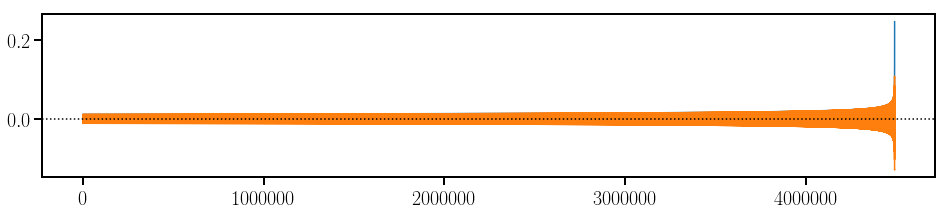

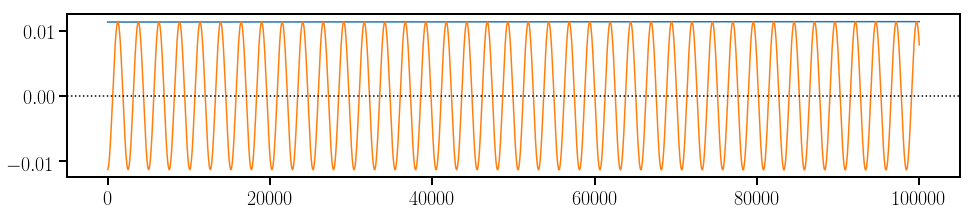

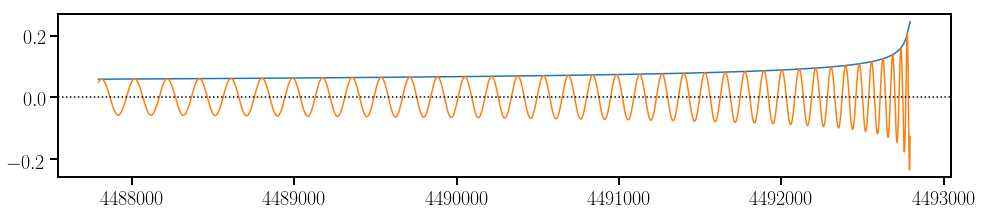

In [203]:
eobdat = np.loadtxt('waveform.dat')

t, hp, hc = eobdat.T
h_resum = wave.Waveform.from_hp_hc(t, hp, hc)

mtot = 2.0
dist = 1.0
h_resum = wave.physical_to_dimensionless_time(h_resum, mtot, dist)

fig, ax = wave.plot_waveforms([h_resum], npoints=100000)
fig, ax = wave.plot_waveforms([h_resum], xi=h_resum.x[0], xf=h_resum.x[0]+1.0e5, npoints=10000)
fig, ax = wave.plot_waveforms([h_resum], xi=h_resum.x[-1]-5000, xf=h_resum.x[-1], npoints=10000)

In [216]:
q = 1.0
s1z = 0.0
s2z = 0.0
lambda1 = 1.0
lambda2 = 1.0

f_min = 40.0
distance = 1.0

approximant = 'TaylorT4'

mtot = 2.0
m1 = mtot/(1.0+q)
m2 = mtot*q/(1.0+q)
print m1, m2, m2/m1

t0 = time.time()
ts, hp, hc = spin_tidal_eob(
    m1, m2, s1z, s2z, lambda1, lambda2,
    f_min, 
    delta_t=1.0/8192.0, distance=distance, inclination=0.0,
    approximant=approximant, 
    dquadmon1=0, dquadmon2=0, 
    verbose=True)
t1 = time.time()
print 'Evaluation time: {}s'.format(t1-t0)

h_t4 = wave.Waveform.from_hp_hc(ts, hp, hc)
h_t4 = wave.physical_to_dimensionless_time(h_t4, mtot, distance)
h_t4.x -= h_t4.x[0]

1.0 1.0 1.0
Approximant: TaylorT4
m1=1.00, m2=1.00
s1z=0.00, s2z=0.00
delta_t=0.000122, 1/delta_t=8192.0, f_min=40.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.0, 0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
Evaluation time: 0.275007963181s


In [214]:
q = 1.0
s1z = 0.0
s2z = 0.0
lambda1 = 1.0
lambda2 = 1.0

f_min = 40.0
distance = 1.0

approximant = 'SEOBNRv4T'

mtot = 2.0
m1 = mtot/(1.0+q)
m2 = mtot*q/(1.0+q)
print m1, m2, m2/m1

t0 = time.time()
ts, hp, hc = spin_tidal_eob(
    m1, m2, s1z, s2z, lambda1, lambda2,
    f_min, 
    delta_t=1.0/8192.0, distance=distance, inclination=0.0,
    approximant=approximant, 
    dquadmon1=None, dquadmon2=None, 
    verbose=True)
t1 = time.time()
print 'Evaluation time: {}s'.format(t1-t0)

h_aei = wave.Waveform.from_hp_hc(ts, hp, hc)
h_aei = wave.physical_to_dimensionless_time(h_aei, mtot, distance)
h_aei.x -= h_aei.x[0]

1.0 1.0 1.0
Approximant: SEOBNRv4T
m1=1.00, m2=1.00
s1z=0.00, s2z=0.00
delta_t=0.000122, 1/delta_t=8192.0, f_min=40.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.3, 0.3, 0.1820, 0.1820, 0.2379, 0.2379, 0.2141, 0.2141
Evaluation time: 89.7772800922s


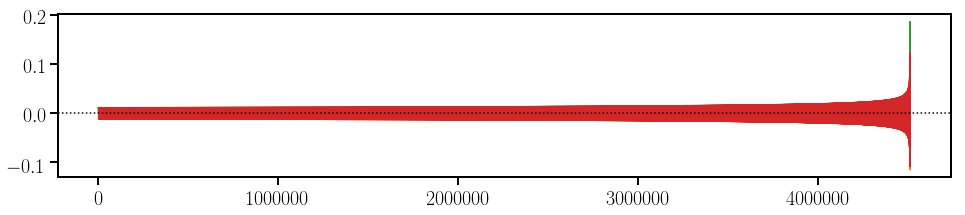

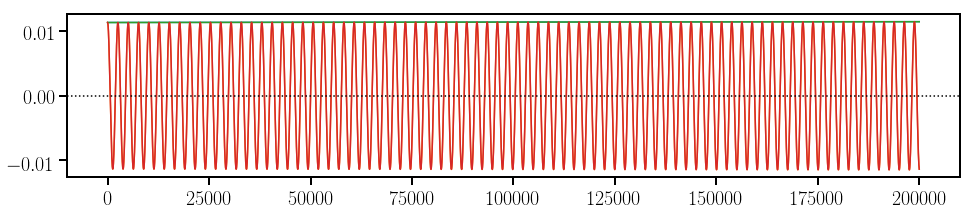

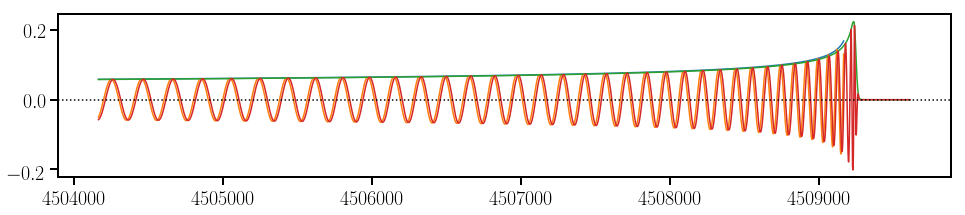

In [217]:
h_t4.phase -= h_t4.phase[0]
h_aei.phase -= h_aei.phase[0]

fig, ax = wave.plot_waveforms([h_t4, h_aei], npoints=100000)
fig, ax = wave.plot_waveforms([h_t4, h_aei], xf=h_t4.x[0]+2.0e5, npoints=100000)
fig, ax = wave.plot_waveforms([h_t4, h_aei], xi=h_t4.x[-1]-5000, xf=h_t4.x[-1]+1000, npoints=100000)

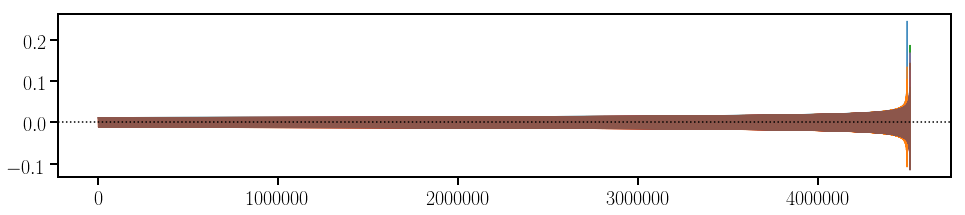

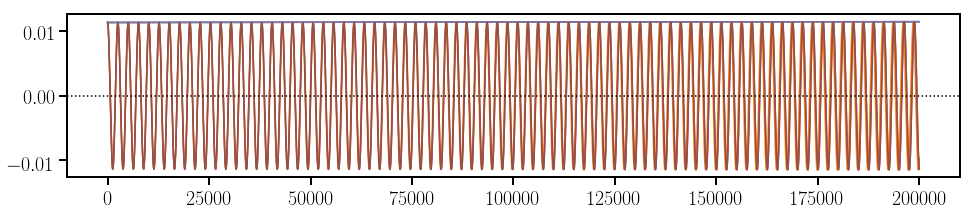

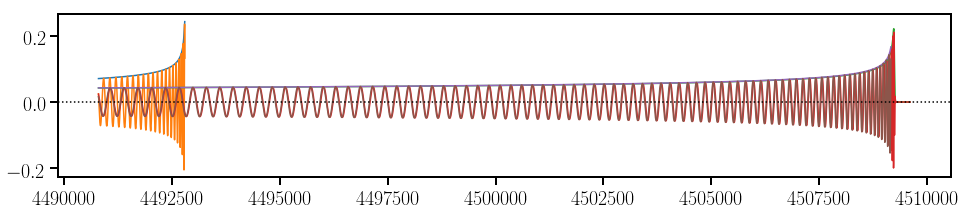

In [218]:
h_resum.phase -= h_resum.phase[0]
h_aei.phase -= h_aei.phase[0]

fig, ax = wave.plot_waveforms([h_resum, h_aei, h_t4], npoints=100000)
fig, ax = wave.plot_waveforms([h_resum, h_aei, h_t4], xf=h_resum.x[0]+2.0e5, npoints=100000)
fig, ax = wave.plot_waveforms([h_resum, h_aei, h_t4], xi=h_resum.x[-1]-2000, xf=h_resum.x[-1]+50000, npoints=100000)

In [210]:
lal.G_SI*lal.MSUN_SI/lal.C_SI**2

1476.6250614046494

# Difference between No QM and QM in time domain

In [281]:
# Largest QM effect:
i = 3

# Small spins makes QM effect small (even when tidal parameters are not small):
#i = 34

h_noqm = hnoqm_list[i]
h_qm = hqm_list[i]

# Zero the start time
#h_noqm.x -= h_noqm.x[0]
#h_qm.x -= h_qm.x[0]

params = params_noqm[i]
print params_noqm[i]
print params_qm[i]

[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]


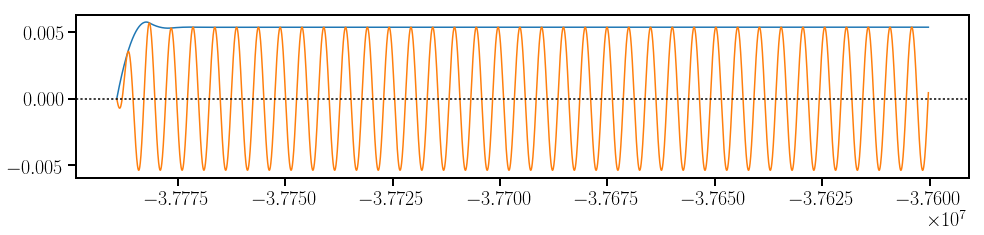

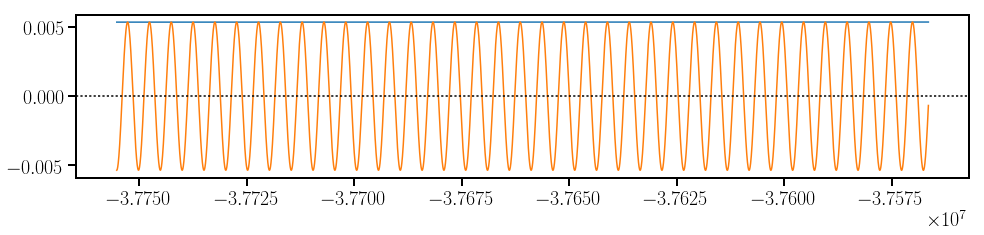

In [282]:
fig, ax = wave.plot_waveforms([h_noqm], xi=h_noqm.x[0], xf=0.995*h_noqm.x[0], npoints=10000)
fig, ax = wave.plot_waveforms([h_qm], xi=h_qm.x[0], xf=0.995*h_qm.x[0], npoints=10000)

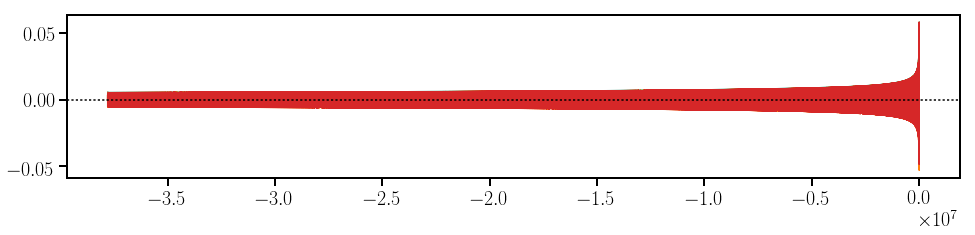

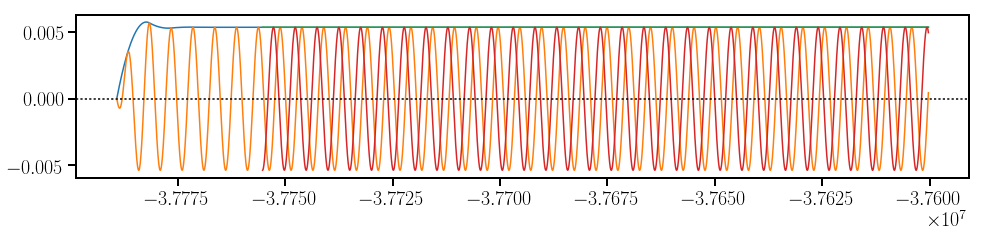

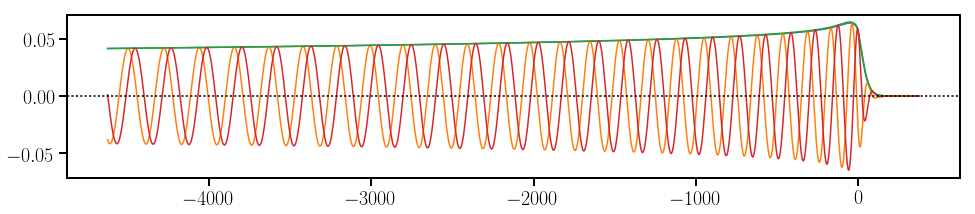

In [283]:
# fig, ax = wave.plot_waveforms([h_noqm, h_qm], xi=0.999*h_noqm.x[-1], xf=1.001*h_noqm.x[-1], npoints=10000)
fig, ax = wave.plot_waveforms([h_noqm, h_qm], npoints=100000)
fig, ax = wave.plot_waveforms([h_noqm, h_qm], xi=h_noqm.x[0], xf=0.995*h_noqm.x[0], npoints=10000)
fig, ax = wave.plot_waveforms([h_noqm, h_qm], xi=h_noqm.x[-1]-5000, xf=h_noqm.x[-1], npoints=10000)

# Difference in frequency domain with current conditioning

In [284]:
# Total mass (M_sun) and starting frequency (Hz) for the waveforms
mtot = 2.0
flow = 20.0

# Start and stop frequencies for Planck window at beginning of waveform
win = 'planck'
winon_i = f_to_mf(flow, mtot)
winon_f = 0.00021


# Sampling interval. 
# Make sure the Nyquist frequency 1/(2*delta_t) is > highest frequency feature in the waveform.
delta_t = 5.0

# Length of the zero-padded time-domain waveform.
# Make it a power of 2.
min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

# Filter with a moving average filter
filter_dfbyf_amp = 0.1
filter_dfbyf_phase = 0.05

# Fit the phase at the beginning to TaylorF2 
# using an interval just big enough to not cause numerical noise
fit_i = winon_f
fit_f = fit_i*(1.0+0.05)

# Truncation frequencies.
# Final conditioned waveform defined in interval [trunc_i, trunc_f].
trunc_i = winon_f
trunc_f = 0.07

# Number of log-spaced points for the final conditioned waveform.
npoints = 10000


print winon_i
print [mf_to_f(mf, mtot) for mf in [winon_i, winon_f, fit_i, fit_f, trunc_i, trunc_f]]

0.000197019641022
[20.0, 21.317671569285263, 21.317671569285263, 22.383555147749526, 21.317671569285263, 7105.890523095088]


In [285]:
h = h_noqm

# Include the 2PN spin-spin term for point particles (quad1=quad2=1), 
# but don't include the 3PN spin-spin term (spin_spin=False).
h_1, hf2_1, dh_1 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    quad1=1.0, quad2=1.0, spin_spin=False, 
    plots=False)

1.0 1.0


In [286]:
h = h_qm

# Include the 2PN spin-spin term with universal relations (quad1=quad2=None), 
# but don't include the 3PN spin-spin term (spin_spin=False).
h_2, hf2_2, dh_2 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    quad1=None, quad2=None, spin_spin=False, 
    plots=False)

11.8705502655 11.8705502655


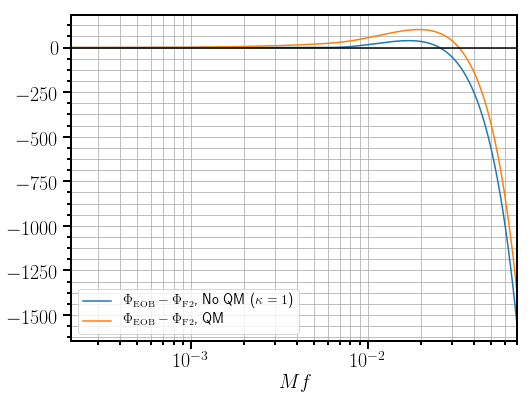

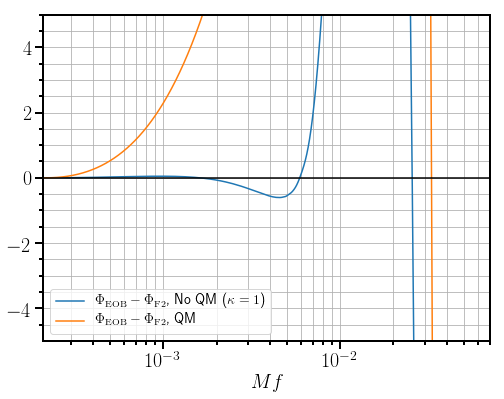

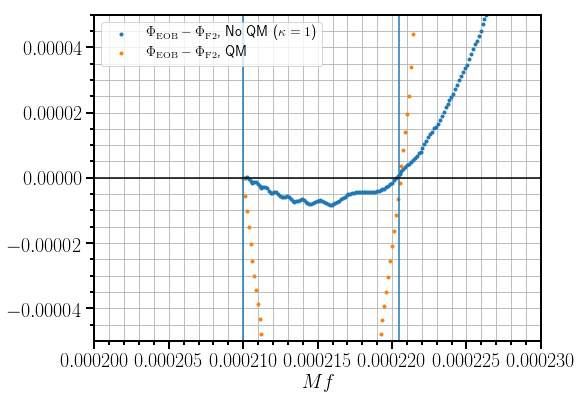

In [287]:
fs = dh_1.x


fig, ax = plt.subplots()
ax.plot(fs, dh_1.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, No QM ($\kappa=1$)')
ax.plot(fs, dh_2.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, QM')
ax.axhline(0, c='k')
ax.set_xscale('log')
ax.set_xlim(0.00021, 0.07)
#ax.set_ylim(-20, 20)
ax.set_xlabel(r'$Mf$')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.plot(fs, dh_1.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, No QM ($\kappa=1$)')
ax.plot(fs, dh_2.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, QM')
ax.axhline(0, c='k')
ax.set_xscale('log')
ax.set_xlim(0.00021, 0.07)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'$Mf$')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.plot(fs, dh_1.phase, '.', label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, No QM ($\kappa=1$)')
ax.plot(fs, dh_2.phase, '.', label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, QM')
ax.axvline(fit_i)
ax.axvline(fit_f)
ax.axhline(0, c='k')
#ax.set_xscale('log')
ax.set_xlim(0.00020, 0.00023)
ax.set_ylim(-5.0e-5, 5.0e-5)
ax.set_xlabel(r'$Mf$')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

In [288]:
hphys_1 = wave.dimensionless_to_physical_freq(h_1, 2.0, 100)
hphys_2 = wave.dimensionless_to_physical_freq(h_2, 2.0, 100)

hphysf2_1 = wave.dimensionless_to_physical_freq(hf2_1, 2.0, 100)
hphysf2_2 = wave.dimensionless_to_physical_freq(hf2_2, 2.0, 100)

dhphys_1 = wave.dimensionless_to_physical_freq(dh_1, 2.0, 100)
dhphys_2 = wave.dimensionless_to_physical_freq(dh_2, 2.0, 100)

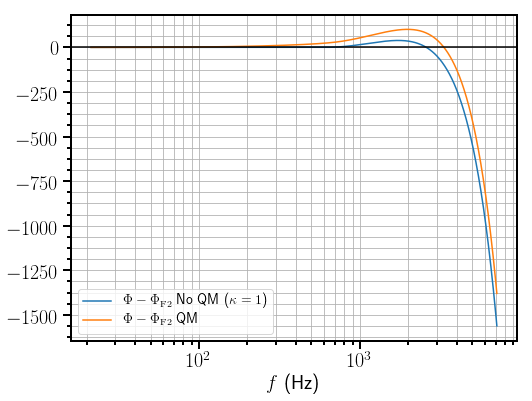

In [289]:
fs = hphysf2_1.x

fig, ax = plt.subplots()
ax.plot(fs, hphys_1.phase-hphysf2_1.phase, label=r'$\Phi-\Phi_{\rm F2}$ No QM ($\kappa=1$)')
ax.plot(fs, hphys_2.phase-hphysf2_2.phase, label=r'$\Phi-\Phi_{\rm F2}$ QM')

ax.axhline(0, c='k')
ax.set_xscale('log')
# ax.set_xlim(10, 2000)
# ax.set_ylim(-200, 200)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

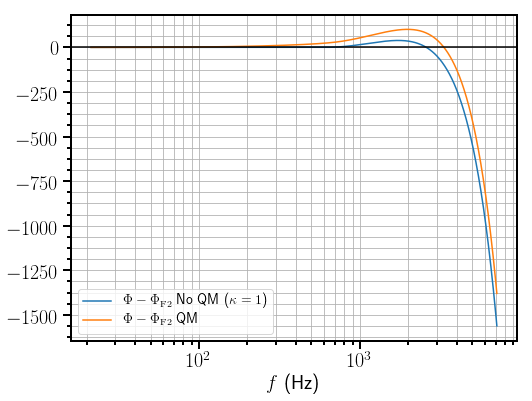

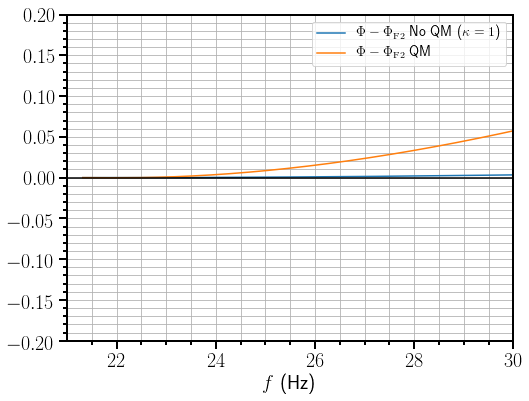

In [290]:
fs = dhphys_1.x

fig, ax = plt.subplots()
ax.plot(fs, dhphys_1.phase, label=r'$\Phi-\Phi_{\rm F2}$ No QM ($\kappa=1$)')
ax.plot(fs, dhphys_2.phase, label=r'$\Phi-\Phi_{\rm F2}$ QM')
ax.axhline(0, c='k')
ax.set_xscale('log')
# ax.set_xlim(10, 2000)
# ax.set_ylim(-200, 200)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.plot(fs, dhphys_1.phase, label=r'$\Phi-\Phi_{\rm F2}$ No QM ($\kappa=1$)')
ax.plot(fs, dhphys_2.phase, label=r'$\Phi-\Phi_{\rm F2}$ QM')
ax.axhline(0, c='k')
#ax.set_xscale('log')
ax.set_xlim(21, 30)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

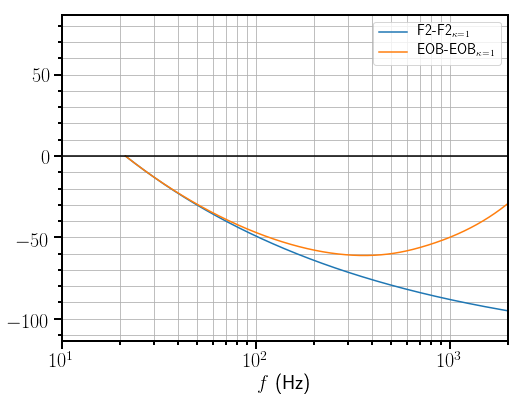

In [291]:
fs = hphysf2_1.x

fig, ax = plt.subplots()
ax.plot(fs, hphysf2_2.phase-hphysf2_1.phase, label=r'F2-F2$_{\kappa=1}$')
ax.plot(fs, hphys_2.phase-hphys_1.phase, label=r'EOB-EOB$_{\kappa=1}$')

ax.axhline(0, c='k')
ax.set_xscale('log')
ax.set_xlim(10, 2000)
#ax.set_ylim(-50, 10)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

# Evaluate QM effect for TaylorF2 and EOB

In [198]:
i = 3

eob_noqm = hnoqm_list[i]
eob_qm = hqm_list[i]

params = params_noqm[i]
print params_noqm[i]
print params_qm[i]


eob_noqm = fourier_transform_waveform(
    eob_noqm, delta_t, n_ext, 
    winon_i, winon_f, trunc_i, trunc_f, 
    npoints=10000, win='planck')

eob_qm = fourier_transform_waveform(
    eob_qm, delta_t, n_ext, 
    winon_i, winon_f, trunc_i, trunc_f, 
    npoints=10000, win='planck')

[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]


In [199]:
print npoints

q, chi1, chi2, lambda1, lambda2 = params

#mf = np.logspace(np.log10(0.00021), np.log10(0.07), npoints)
mf = eob_noqm.x
print mf[0], mf[-1]

# Include the 2PN spin-spin term for point particles (quad1=quad2=1), 
# but don't include the 3PN spin-spin term (spin_spin=False).
f2_noqm = f2.dimensionless_taylorf2_waveform(
    mf=mf, q=q,
    spin1x=0, spin1y=0, spin1z=chi1,
    spin2x=0, spin2y=0, spin2z=chi2,
    lambda1=lambda1, lambda2=lambda2,
    quad1=1.0, quad2=1.0, spin_spin=False)

# Include the 2PN spin-spin term with universal relations (quad1=quad2=None), 
# but don't include the 3PN spin-spin term (spin_spin=False).
f2_qm = f2.dimensionless_taylorf2_waveform(
    mf=mf, q=q,
    spin1x=0, spin1y=0, spin1z=chi1,
    spin2x=0, spin2y=0, spin2z=chi2,
    lambda1=lambda1, lambda2=lambda2,
    quad1=None, quad2=None, spin_spin=False)

10000
0.00021 0.07
1.0 1.0
11.8705502655 11.8705502655


In [200]:
fi = fit_i
ff = fit_f

#fi = 0.00025
#ff = fit_i*(1.0+1.5)

print fi, ff
print mf_to_f(fi, 2.0), mf_to_f(ff, 2.0)

# zero slopes at beginning
eob_noqm = zero_start_slope(eob_noqm, fi, ff)
eob_qm = zero_start_slope(eob_qm, fi, ff)

f2_noqm = zero_start_slope(f2_noqm, fi, ff)
f2_qm = zero_start_slope(f2_qm, fi, ff)


# Convert to physical units
eobphys_noqm = wave.dimensionless_to_physical_freq(eob_noqm, 2.0, 100)
eobphys_qm = wave.dimensionless_to_physical_freq(eob_qm, 2.0, 100)

f2phys_noqm = wave.dimensionless_to_physical_freq(f2_noqm, 2.0, 100)
f2phys_qm = wave.dimensionless_to_physical_freq(f2_qm, 2.0, 100)

0.00021 0.0002205
21.3176715693 22.3835551477


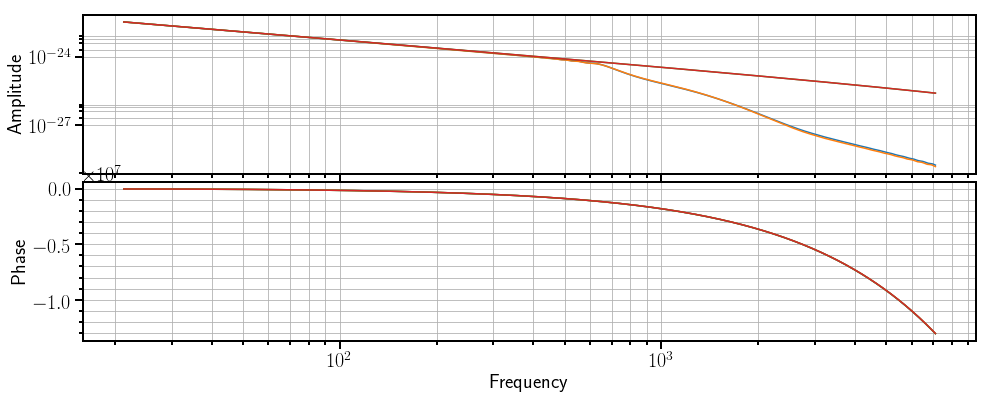

In [201]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([eobphys_noqm, eobphys_qm, f2phys_noqm, f2phys_qm])
ax1.set_yscale('log')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

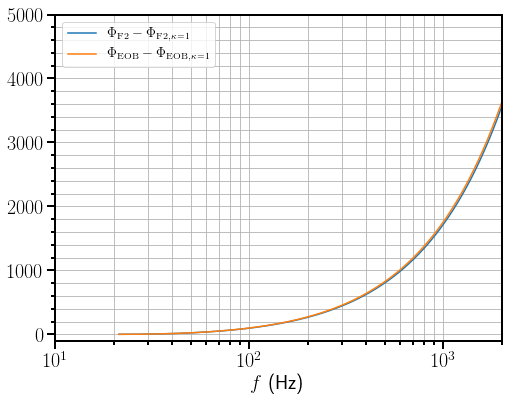

In [204]:
fs = f2phys_noqm.x

fig, ax = plt.subplots()
ax.plot(fs, f2phys_qm.phase-f2phys_noqm.phase, label=r'$\Phi_{\rm F2}-\Phi_{\rm F2, \kappa=1}$')
ax.plot(fs, eobphys_qm.phase-eobphys_noqm.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm EOB, \kappa=1}$')

ax.set_xscale('log')
ax.set_xlim(10, 2000)
ax.set_ylim(-100, 5000)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

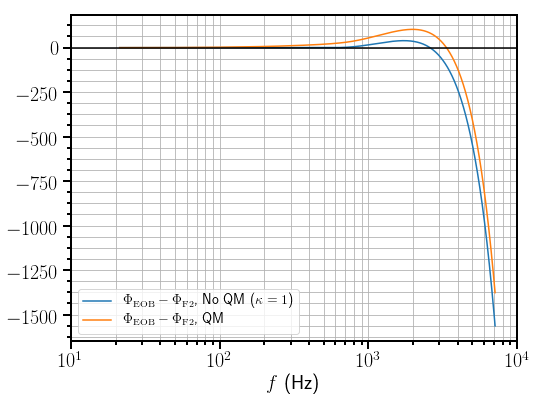

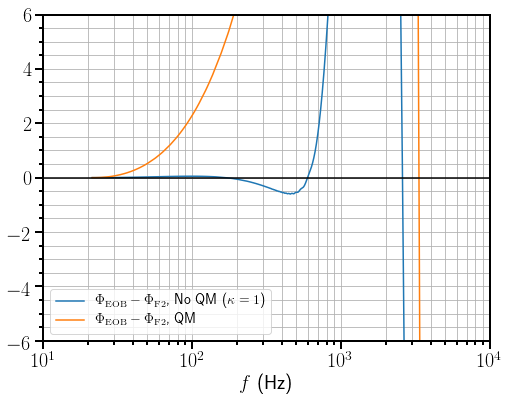

In [206]:
fs = f2phys_noqm.x


fig, ax = plt.subplots()
ax.plot(fs, eobphys_noqm.phase-f2phys_noqm.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, No QM ($\kappa=1$)')
ax.plot(fs, eobphys_qm.phase-f2phys_qm.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, QM')

ax.axhline(0, c='k')
ax.set_xscale('log')
ax.set_xlim(10, 10000)
#ax.set_ylim(-3500, 500)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.plot(fs, eobphys_noqm.phase-f2phys_noqm.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, No QM ($\kappa=1$)')
ax.plot(fs, eobphys_qm.phase-f2phys_qm.phase, label=r'$\Phi_{\rm EOB}-\Phi_{\rm F2}$, QM')

ax.axhline(0, c='k')
ax.set_xscale('log')
ax.set_xlim(10, 10000)
ax.set_ylim(-6, 6)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

# Compare lalsuite TaylorF2 phase to your TaylorF2 phase

In [207]:
print npoints

q, chi1, chi2, lambda1, lambda2 = params
print params

mf = np.logspace(np.log10(0.00021), np.log10(0.07), npoints)
#mf = eob_noqm.x
print mf[0], mf[-1]

10000
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]
0.00021 0.07


In [208]:
mf_min = mf[0]
mf_max = mf[-1]

f2_noqm = lalwaveform.dimensionless_fd_waveform(
    approximant='TaylorF2', 
    q=q, spin1z=chi1, spin2z=chi2, lambda1=lambda1, lambda2=lambda2, quad1=1, quad2=1,
    mf_min=mf_min, mf_max=mf_max, delta_mf=1.0e-8)
f2_noqm.resample(mf)

f2_qm = lalwaveform.dimensionless_fd_waveform(
    approximant='TaylorF2', 
    q=q, spin1z=chi1, spin2z=chi2, lambda1=lambda1, lambda2=lambda2, quad1=None, quad2=None,
    mf_min=mf_min, mf_max=mf_max, delta_mf=1.0e-8)
f2_qm.resample(mf)

# f2_qm = lalwaveform.dimensionless_fd_waveform(
#     approximant='TaylorF2', 
#     q=q, spin1z=chi1, spin2z=chi2, lambda1=lambda1, lambda2=lambda2, quad1=11.87, quad2=11.87,
#     mf_min=mf_min, mf_max=mf_max, delta_mf=1.0e-8)
# f2_qm.resample(mf)

1 1
dQuadMon1 = 0.0
dQuadMon2 = 0.0
11.8705502655 11.8705502655
dQuadMon1 = 10.8705502655
dQuadMon2 = 10.8705502655


In [210]:
fi = fit_i
ff = fit_f

#fi = 0.00025
#ff = fit_i*(1.0+1.5)

print fi, ff
print mf_to_f(fi, 2.0), mf_to_f(ff, 2.0)

f2_noqm = zero_start_slope(f2_noqm, fi, ff)
f2_qm = zero_start_slope(f2_qm, fi, ff)

f2phys_noqm = wave.dimensionless_to_physical_freq(f2_noqm, 2.0, 100)
f2phys_qm = wave.dimensionless_to_physical_freq(f2_qm, 2.0, 100)

0.00021 0.0002205
21.3176715693 22.3835551477


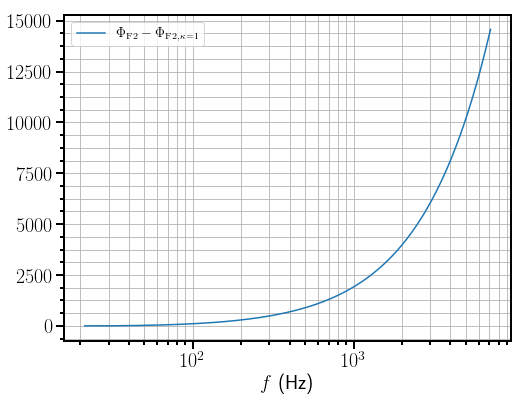

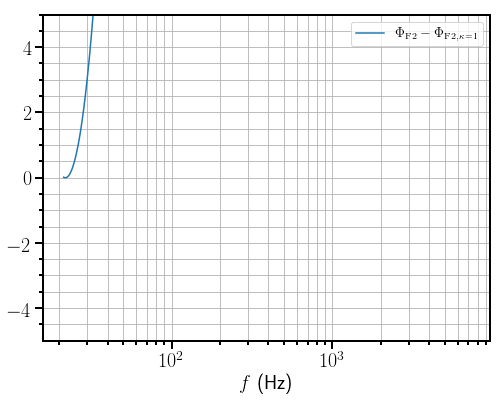

In [222]:
fs = f2phys_noqm.x


fig, ax = plt.subplots()
ax.plot(fs, f2phys_qm.phase-f2phys_noqm.phase, label=r'$\Phi_{\rm F2}-\Phi_{\rm F2, \kappa=1}$')
ax.set_xscale('log')
#ax.set_xlim(10, 2000)
#ax.set_ylim(-5000, 5000)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.plot(fs, f2phys_qm.phase-f2phys_noqm.phase, label=r'$\Phi_{\rm F2}-\Phi_{\rm F2, \kappa=1}$')
ax.set_xscale('log')
#ax.set_xlim(10, 2000)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

# Only using physical units

In [212]:
npoints=10000
fs = np.logspace(np.log10(20), np.log10(2000), npoints)
                 
q, chi1, chi2, lambda1, lambda2 = params

mtot = 2.0
mass1 = mtot/(1.0+q)
mass2 = mtot*q/(1.0+q)

print mass1, mass2
print params

1.5 0.5
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]


In [213]:
delta_f=1.0e-3

f_min = fs[0]
f_max = fs[-1]

f2_noqm = lalwaveform.lalsim_fd_waveform(
    approximant='TaylorF2', 
    distance=100, inclination=0.0, 
    mass1=mass1, mass2=mass2, 
    spin1x=0.0, spin1y=0.0, spin1z=chi1, 
    spin2x=0.0, spin2y=0.0, spin2z=chi2, 
    lambda1=lambda1, lambda2=lambda2, 
    quad1=1.0, quad2=1.0,
    f_min=f_min, f_max=f_max, delta_f=delta_f)
f2_noqm.resample(fs)

f2_qm = lalwaveform.lalsim_fd_waveform(
    approximant='TaylorF2', 
    distance=100, inclination=0.0, 
    mass1=mass1, mass2=mass2, 
    spin1x=0.0, spin1y=0.0, spin1z=chi1, 
    spin2x=0.0, spin2y=0.0, spin2z=chi2, 
    lambda1=lambda1, lambda2=lambda2, 
    quad1=None, quad2=None,
    f_min=f_min, f_max=f_max, delta_f=delta_f)
f2_qm.resample(fs)

1.0 1.0
dQuadMon1 = 0.0
dQuadMon2 = 0.0
11.8705502655 11.8705502655
dQuadMon1 = 10.8705502655
dQuadMon2 = 10.8705502655


In [214]:
df=1.0
f2_noqm = zero_start_slope(f2_noqm, f_min, f_min+df)
f2_qm = zero_start_slope(f2_qm, f_min, f_min+df)

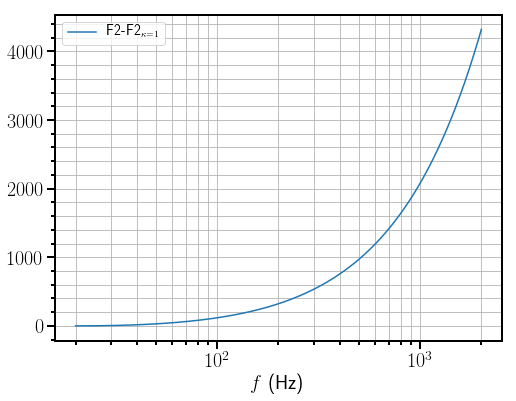

In [215]:
fig, ax = plt.subplots()
ax.plot(fs, f2_qm.phase-f2_noqm.phase, label=r'F2-F2$_{\kappa=1}$')

ax.set_xscale('log')
#ax.set_xlim(10, 2000)
#ax.set_ylim(-5000, 5000)
#ax.set_xlim(18, 30)
#ax.set_ylim(-5, 5)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

# Analytic, 2PN, matter-only, QM phase accumulation 

In [216]:
def spin_qm_phase(mf, eta, chi1, chi2, quad1, quad2):
    """The part of the spin that results from quad1 and quad2 not being 1.
    """
    a00 = 3.0/(128.0*eta)
    
    x = (np.pi*mf)**(2.0/3.0)
    
    a20 = f2.taylorf2_phase_20pn_spin(eta, chi1, chi2, quad1, quad2)
    phi_qm = -a00*x**(-5.0/2.0)*(a20*x**2.0)
    
    quad1 = 1.0
    quad2 = 1.0
    a20 = f2.taylorf2_phase_20pn_spin(eta, chi1, chi2, quad1, quad2)
    phi_noqm = -a00*x**(-5.0/2.0)*(a20*x**2.0)
    
    return phi_qm - phi_noqm

In [217]:
eta = q/(1.+q)**2

mf = f_to_mf(fs, 2.0)
quad1 = 11.87
quad2 = 11.87
dphase = spin_qm_phase(mf, eta, chi1, chi2, quad1, quad2)

In [218]:
dphase

array([ 124.55938504,  124.54026402,  124.52114594, ...,   26.8437469 ,
         26.83962614,   26.83550601])

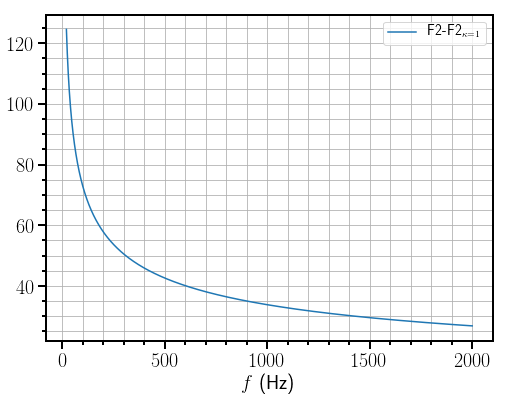

In [219]:
fig, ax = plt.subplots()
ax.plot(fs, dphase, label=r'F2-F2$_{\kappa=1}$')

#ax.set_xscale('log')
#ax.set_xlim(10, 2000)
#ax.set_ylim(-5000, 5000)
#ax.set_xlim(18, 30)
#ax.set_ylim(-5, 5)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

In [220]:
h_dphase = wave.Waveform.from_amp_phase(fs, np.zeros(len(fs)), dphase)

df=4.0
h_dphase = zero_start_slope(h_dphase, f_min, f_min+df)

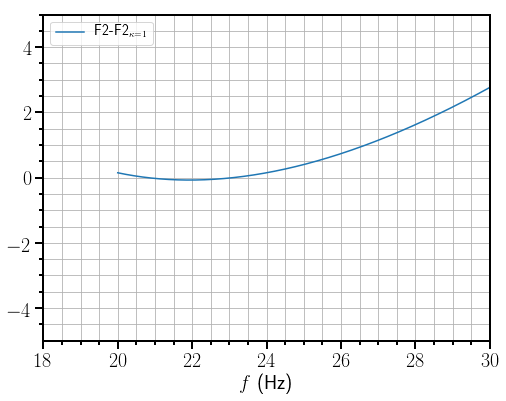

In [221]:
fig, ax = plt.subplots()
ax.plot(h_dphase.x, h_dphase.phase, label=r'F2-F2$_{\kappa=1}$')

#ax.set_xscale('log')
#ax.set_xlim(10, 2000)
#ax.set_ylim(-5000, 5000)
ax.set_xlim(18, 30)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'$f$ (Hz)')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()